In [1]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

import matplotlib as mpl

pb.ion()

file_base = ""

In [2]:
X_raw = np.load("hc_G6_test.npy", allow_pickle=True)
Y_raw = np.load("samples_G6_test.npy", allow_pickle=True)

In [3]:
scales = np.load("../standard_k.npy", allow_pickle=True)

In [4]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [5]:
m = pickle.load(open("analyses/massive_emulator_G7.nucomet", "rb"))

In [6]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * m.ystdev + m.ymu)

In [7]:
def xtransform(configuration):
    return (np.log(configuration) - m.xmu) / m.xstdev

In [8]:
def nest(array):
    return np.array([np.array(array)])

In [9]:
preds = np.zeros(Y.shape)
rel_errors = np.zeros(Y.shape)

for i in range(len(X)):
    x = xtransform(nest(X[i]))
    raw_pred, _ = m.predict(x)
    preds[i] = inverse_ytransform(raw_pred)
    rel_errors[i] = (preds[i] - Y[i]) / Y[i]

[2.15785750e-02 1.36177000e-01 9.73865000e-01 8.32239993e-01
 2.56269744e-09 6.73700000e-03]


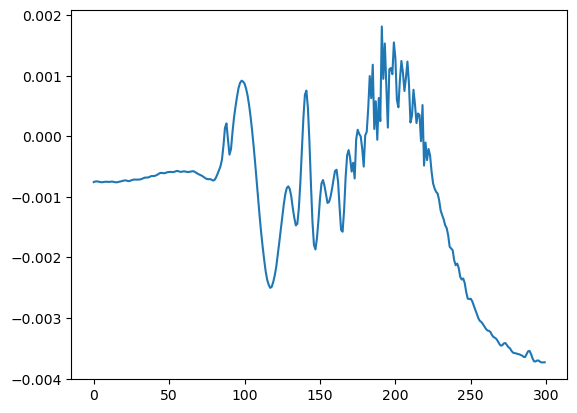

In [10]:
# An example of an extreme error plot, with the cosmology it was
# supposed to describe. 

pb.plot(rel_errors[900] * 100)
print(X[900])

In [11]:
min(X[:, 3])

0.20008000060333042

In [12]:
max(X[:, 3])

0.9999201620474477

In [13]:
def normalize(array):
    min_ = min(array)
    max_ = max(array)
    range_ = max_ - min_
    shifted = array - min_
    return shifted / range_

In [14]:
# Let's use the plasma color map
def plot_colored_errors(param_index, param_label, save_label=None):
    normalized_vals = normalize(X[:, param_index])
    colors = pb.cm.plasma(normalized_vals)

    for i in range(len(rel_errors)):
        if i % 1 == 0:
            pb.plot(scales, 100 * rel_errors[i],
                color=colors[i], alpha=0.05)
            pb.xscale('log')

    pb.title(r"Emulator G3, 5000 Random Massive-$\nu$ Models" + 
            "\ncolored by " + param_label + " value")
    pb.ylabel("% error between CAMB and CassL")
    pb.xlabel("scale $k$ [1 / Mpc]")
    norm = mpl.colors.Normalize(
        vmin=min(X[:, param_index]), vmax=max(X[:, param_index]))
    pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma, norm=norm))
    # Momentarily eliminate saving so that we don't keep crashing on the
    # incomplete file handles.
    #if save_label is not None:
    #    pb.savefig("../plots/emulator/performance/" + save_label + ".png")

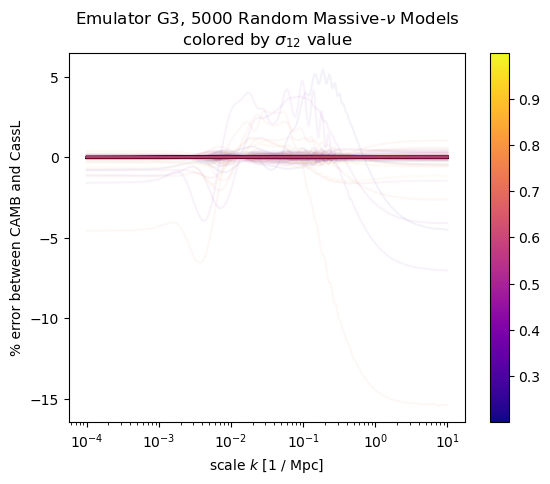

In [15]:
plot_colored_errors(3, r"$\sigma_{12}$")

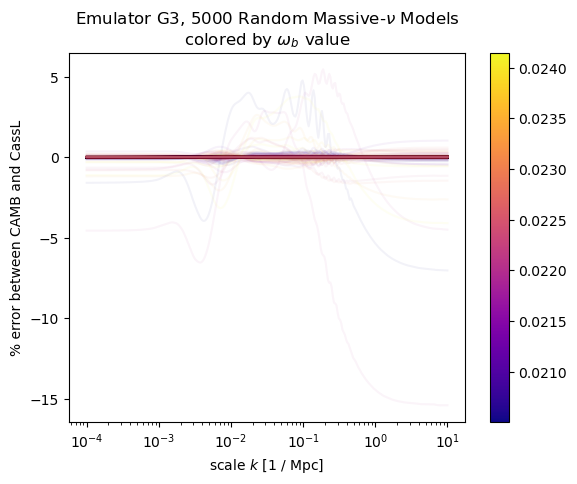

In [16]:
plot_colored_errors(0, r"$\omega_b$")

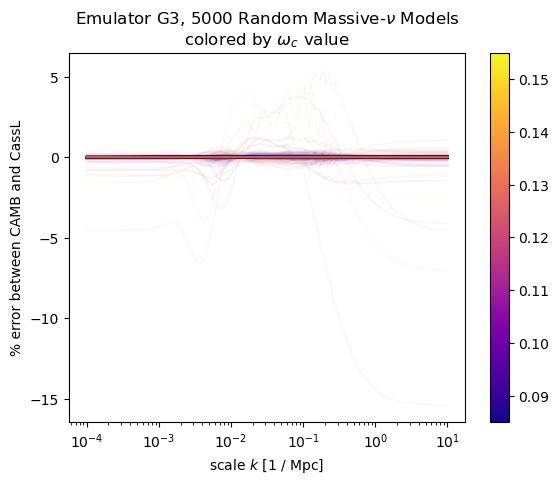

In [17]:
plot_colored_errors(1, r"$\omega_c$")

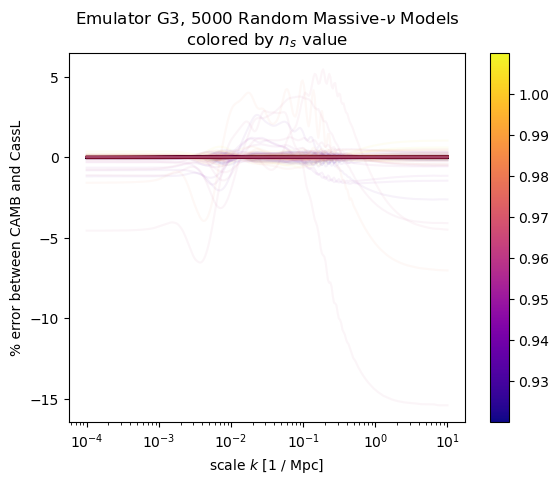

In [18]:
plot_colored_errors(2, r"$n_s$")

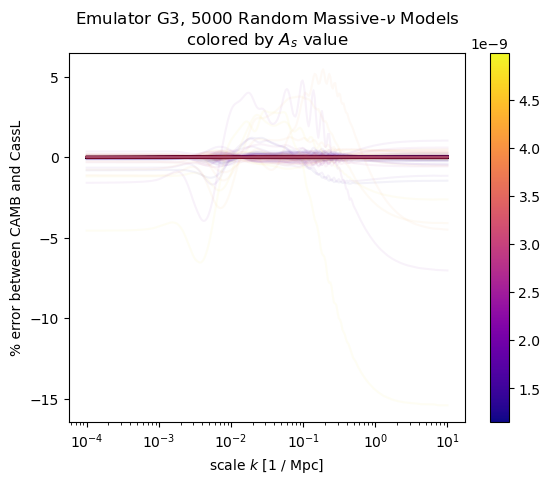

In [19]:
plot_colored_errors(4, r"$A_s$", "_colored_by_As")

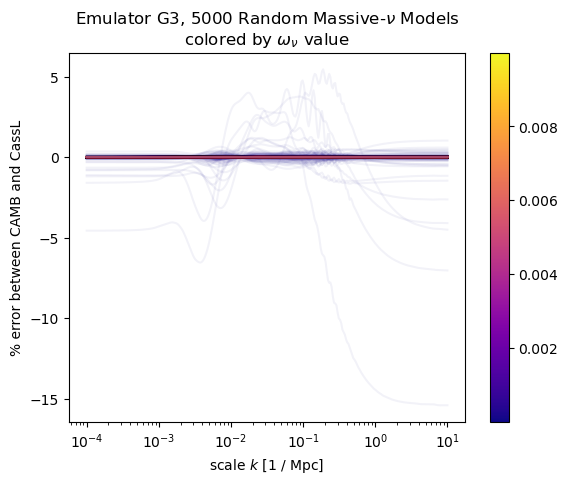

In [20]:
plot_colored_errors(5, r"$\omega_\nu$", "_colored_by_omnu")

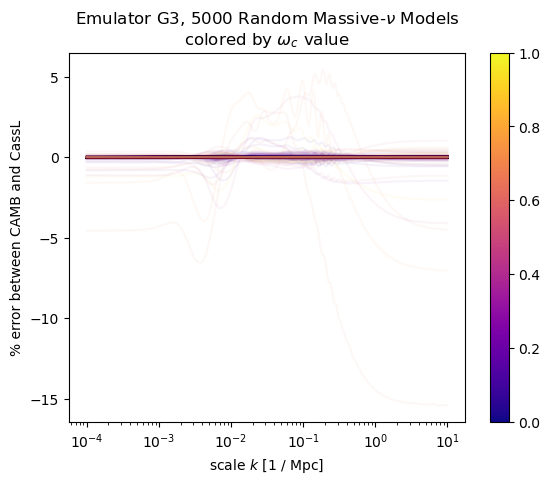

In [22]:
# Let's use the plasma color map
normalized_omc_vals = normalize(X[:, 1])
colors_omc = pb.cm.plasma(normalized_omc_vals)

for i in range(len(rel_errors)):
    if i % 1 == 0:
        pb.plot(scales, 100 * rel_errors[i],
            color=colors_omc[i], alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator G3, 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_c$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma))
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

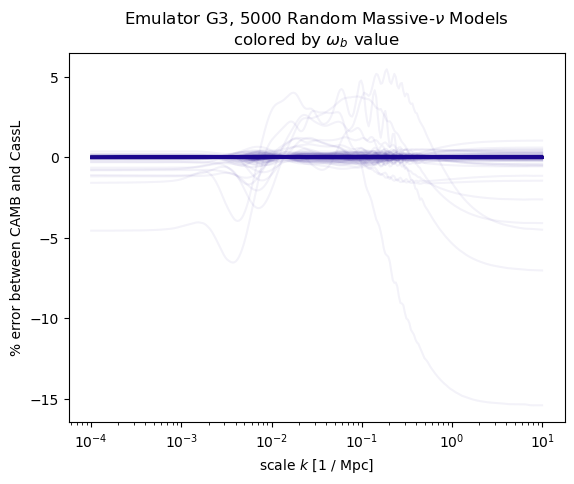

In [23]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color=pb.cm.plasma(X[i][0]), alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator G3, 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_b$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

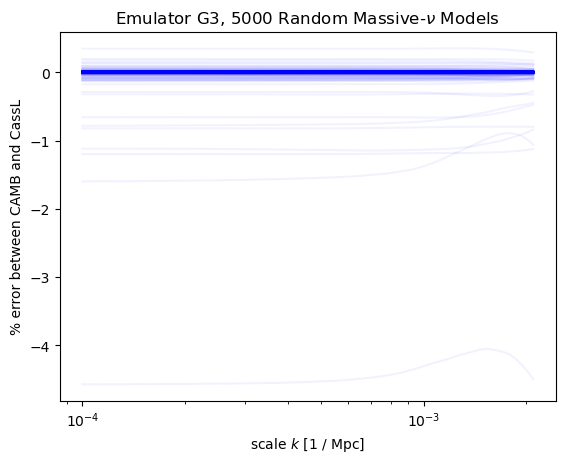

In [25]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales[:80], 100 * rel_errors[i][:80],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator G3, 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

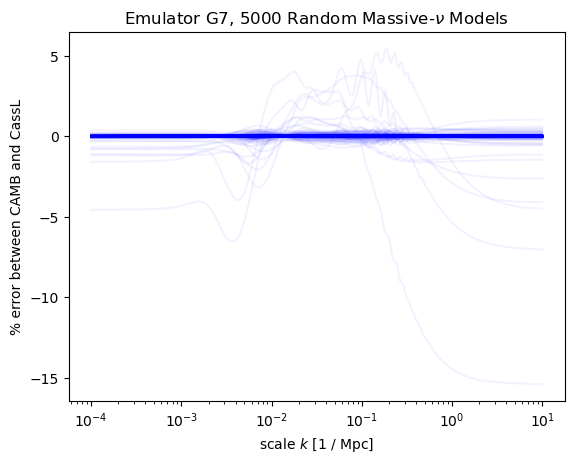

In [44]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator G7, 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.savefig("../../plots/emulator/performance/massive_5k_G7.png")

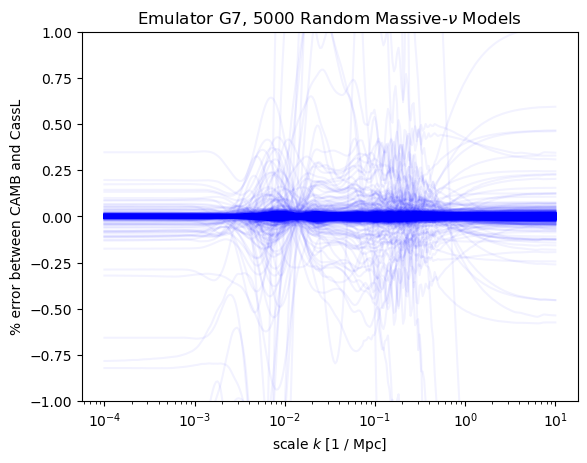

In [42]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator G7, 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.ylim((-1, 1))
pb.savefig("../../plots/emulator/performance/massive_5k_G7_zoom.png")